In [ ]:
from pathlib import Path
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

datadir = Path("./../")

# Load DataFrames with embedding ids and texts
df_acts_filename = datadir / "tinystories1M-TinyStories1_gpt2token-acts_id.csv"
df_texts_filename = datadir / "tinystories1M-TinyStories1_gpt2token-texts.csv"
df_acts_tokens = pd.read_csv(df_acts_filename, header=None, skiprows=1)
df_texts = pd.read_csv(df_texts_filename, header=None, skiprows=1)

# Load embedding matrix
with open(datadir / 'emb_matrix.npy', 'rb') as f:
    embs_flat = np.load(f)

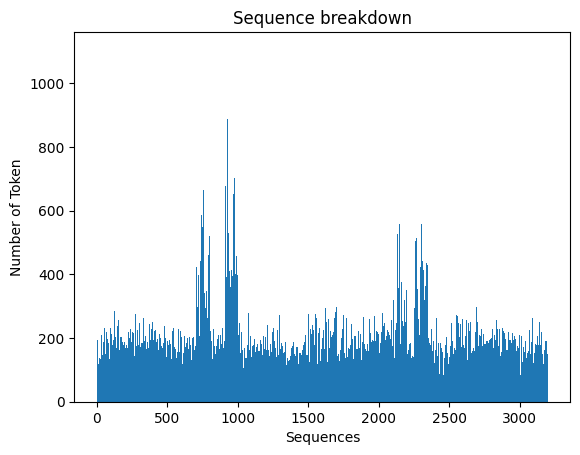

In [4]:
# TEST sequence id
plt.hist(df_acts_tokens.iloc[:,2], bins=df_acts_tokens.iloc[:,2].nunique())
plt.title("Sequence breakdown")
plt.xlabel("Sequences")
plt.ylabel("Number of Token")
plt.show()

In [6]:
# fit PCA 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

N_COMPONENTS = 10
RANDOM_STATE = 42
TOP_TOKEN = 10

scaler = StandardScaler()
embs_scaled = scaler.fit_transform(embs_flat)

# check norm of embs_scaled and each row equals to 1
print("Norm of embs_scaled:", np.linalg.norm(embs_scaled))
print("Norm of each row of embs_scaled:", np.linalg.norm(embs_scaled, axis=1))
# Fit PCA with random state
pca = PCA(n_components=N_COMPONENTS, random_state=RANDOM_STATE)
pca.fit_transform(embs_scaled)

# 20 principal components
principal_components = pca.components_[:N_COMPONENTS,:]
print("Principal Components Shape:", principal_components.shape)

Norm of embs_scaled: 6606.693
Norm of each row of embs_scaled: [ 9.750103   9.866186  10.430297  ...  6.6046944  7.127592   6.9076996]
Principal Components Shape: (10, 64)


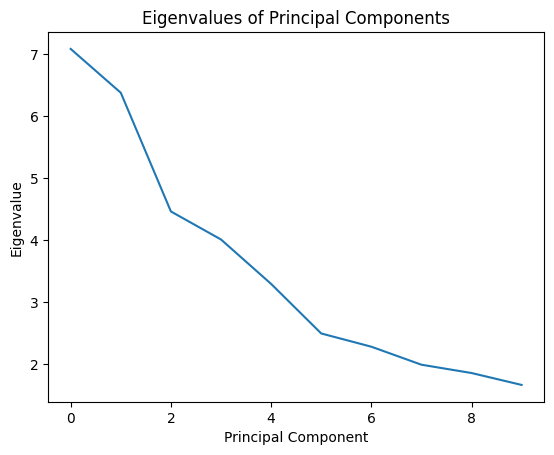

In [7]:
# plot Eigenvalues of Principal Components
plt.plot(pca.explained_variance_)
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues of Principal Components')
plt.show()


In [ ]:
from sklearn.preprocessing import normalize
print("embs_flat shape:", embs_flat.shape)
normalized_embeddings = normalize(embs_flat, axis=1)
print("shape of normalized_embeddings:", normalized_embeddings.shape)
print("normalized_embeddings:", np.linalg.norm(normalized_embeddings, axis=1))
print(principal_components.shape)
print(np.linalg.norm(principal_components, axis=1))

embs_flat shape: (682595, 64)
shape of normalized_embeddings: (682595, 64)
normalized_embeddings: [1. 1. 1. ... 1. 1. 1.]
(10, 64)
[0.99999994 1.         1.0000001  1.0000006  1.0000002  0.99999994
 0.99999994 1.0000002  1.0000001  1.0000004 ]


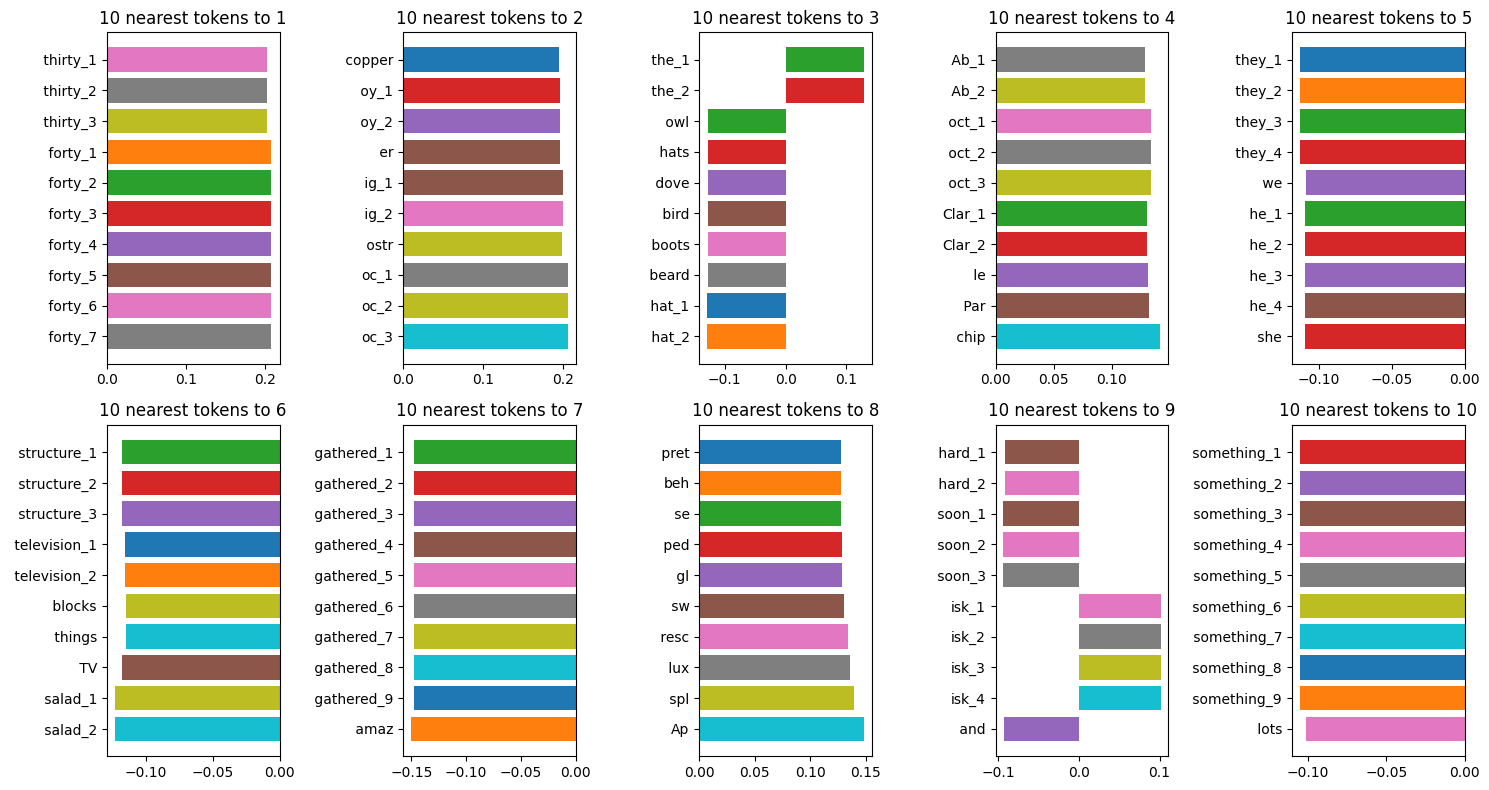

In [8]:
top_k = 10  # Number of top tokens to retrieve per component
token_ids = df_acts_tokens.iloc[:,1]

# Visualize the top tokens for each principal component
fig, axes = plt.subplots(2,5, figsize=(15, 8))
axis = axes.flatten()

for i in range(N_COMPONENTS):  # For each principal component
 
    component_projections = np.dot(embs_flat, principal_components[i,:])  # projection of each embedding onto the component
    top_indices = np.argsort(np.abs(component_projections))[-top_k:]

    axis[i].set_title(f'10 nearest tokens to {i+1}')
    # Check for duplicate token_ids and create new rows
    unique_token_ids = token_ids.iloc[top_indices].duplicated(keep=False)
    for idx, is_duplicate in zip(top_indices, unique_token_ids):
        if is_duplicate:
            count = token_ids.iloc[top_indices].value_counts()[token_ids.iloc[idx]]
            for j in range(count):
                axis[i].barh(str(token_ids.iloc[idx]) + f'_{j+1}', component_projections[idx])
        else:
            axis[i].barh(token_ids.iloc[idx], component_projections[idx])
    axis[i].invert_yaxis()

plt.tight_layout()
plt.show()

In [ ]:
# Oja rule for PCA
import numpy as np
import sklearn
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

import numpy as np
from sklearn.preprocessing import StandardScaler



scaler = StandardScaler(with_std=False)
Xs = scaler.fit_transform(embs_flat)

n_features=Xs.shape[1]
n_components = 100

W_sanger = np.random.normal(scale=0.1, size=(n_components, n_features))
prev_W_sanger = np.ones((n_components, n_features))

# Time-based learning rate decay
t = 0.0
learning_rate = 0.01

# Sanger's Rule algorithm
for i in tqdm(range(5)):
    prev_W_sanger = W_sanger.copy()
    dw = np.zeros((n_components, n_features))
    t += 1.0
    
    for j in range(Xs.shape[0]):
        Ysj = np.dot(W_sanger, Xs[j]).reshape((n_components, 1))
        
        # Compute triangular matrix for Sanger's rule
        QYd = np.tril(np.dot(Ysj, Ysj.T))
        dw += np.dot(Ysj, Xs[j].reshape((1, n_features))) - np.dot(QYd, W_sanger)
        
    # Update weights 
    W_sanger += (learning_rate / t) * dw
    
    # Normalize weight vectors (to maintain orthonormality)
    W_sanger /= np.linalg.norm(W_sanger, axis=1).reshape((n_components, 1))



100%|██████████| 5/5 [06:19<00:00, 75.86s/it]


W_sanger shape: (100, 64)
dw shape: (100, 64)


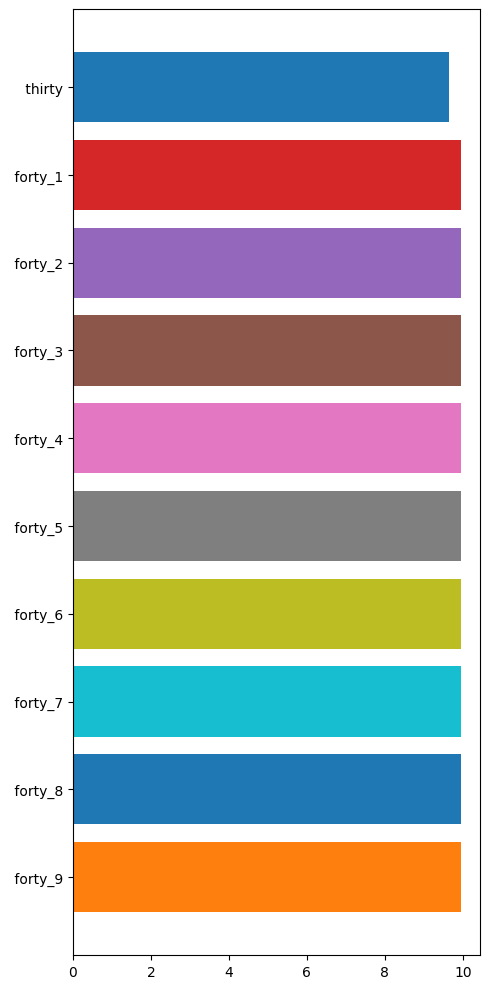

In [22]:
TOP_TOKEN = 10
N_COMPONENTS = 1
print("W_sanger shape:", W_sanger.shape)
print("dw shape:", dw.shape)    
top_component_index = np.argsort(np.linalg.norm(dw, axis=1), axis=0)[-10:]
top_component = W_sanger[top_component_index[::-1]]
token_ids = df_acts_tokens.iloc[:,1]  
scaler = StandardScaler()
embs_scaled = scaler.fit_transform(embs_flat.reshape(-1, 64))

fig, axes = plt.subplots(figsize=(5, 10))

for i in range(N_COMPONENTS):  # For each principal component
    component_projections_trained = np.dot(embs_scaled, top_component[i,:])  
    top_indices = np.argsort(np.abs(component_projections_trained))[-top_k:]
    # Check for duplicate token_ids and create new rows
    unique_token_ids = token_ids.iloc[top_indices].duplicated(keep=False)
    for idx, is_duplicate in zip(top_indices, unique_token_ids):
        if is_duplicate:
            count = token_ids.iloc[top_indices].value_counts()[token_ids.iloc[idx]]
            for j in range(count):
                axes.barh(str(token_ids.iloc[idx]) + f'_{j+1}', component_projections_trained[idx])
        else:
            axes.barh(token_ids.iloc[idx], component_projections_trained[idx])
    axes.invert_yaxis()

plt.tight_layout()
plt.show()


# fig, axes = plt.subplots(1, N_COMPONENTS, figsize=(5, 10))
# axes.flatten()

# for i in range(N_COMPONENTS):  # For each principal component
#     component_projections_trained = np.dot(embs_scaled, top_component[i,:])  
#     top_indices = np.argsort(np.abs(component_projections_trained))[-top_k:]
#     # Check for duplicate token_ids and create new rows
#     unique_token_ids = token_ids.iloc[top_indices].duplicated(keep=False)
#     for idx, is_duplicate in zip(top_indices, unique_token_ids):
#         if is_duplicate:
#             count = token_ids.iloc[top_indices].value_counts()[token_ids.iloc[idx]]
#             for j in range(count):
#                 axes[i].barh(str(token_ids.iloc[idx]) + f'_{j+1}', component_projections_trained[idx])
#         else:
#             axes[i].barh(token_ids.iloc[idx], component_projections_trained[idx])
#     axes[i].invert_yaxis()

# plt.tight_layout()
# plt.show()